In [51]:
import os
import typing
from typing import Tuple

import numpy as np
import pandas as pd

# OpenCV and Scikit-Image for image manipulation
# This code prefers skimage for resize but you can also import and use cv2
from skimage.transform import resize
from skimage.measure import label, regionprops, perimeter
from skimage.morphology import binary_dilation, square

# Seaborn and Matplotlib for plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-Learn and helper functions
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, homogeneity_score, completeness_score

from skimage.feature import graycomatrix, graycoprops


FAIL = 2 # failing die
PASS = 1 # passing die
NO_DIE = 0 # no die
RANDOM_SEED = 10

In [52]:
#validating failure type sample sizes for testing and training
train_data = np.load("data/wafermap_train.npy", allow_pickle=True)
test_data = np.load("data/wafermap_test.npy", allow_pickle=True)

df_train = pd.DataFrame({name: train_data[name] for name in train_data.dtype.names})
df_test = pd.DataFrame({name: test_data[name] for name in test_data.dtype.names})

In [53]:
# TODO: Create dictionary called 'string2int' for converting string to numeric number
string2int = {
    'Center': 0,
    'Donut': 1,
    'Edge-Loc': 2,
    'Near-full': 3,
    'Scratch': 4
}

In [54]:
def convert_failure_type(failure_type: str) -> int:
    return string2int[failure_type]

def resize_wafer_map(wafer_map: np.ndarray, output_shape: tuple=(64, 64)) -> np.ndarray:
    return resize(wafer_map, output_shape, order=0, anti_aliasing=False, preserve_range=True)

In [55]:
# TODO: Implement a function that creates dataframe columns to store the return values of the two tasks below using convert_failure_type and resize_wafer_map:
#       (1) reshapes the wafer maps as a numpy array of shape (64, 64)
#       (2) converts the failureType into numeric values
def prepare_data(df: pd.DataFrame, has_labels: bool=True) -> Tuple[np.ndarray, list]:
    df["waferMap_resized"] = df["waferMap"].apply(lambda x: resize_wafer_map(x))

    if has_labels:
        df["failureType_num"] = df["failureType"].apply(convert_failure_type)
        labels = df["failureType_num"].tolist()
    else:
        labels = None

    return df, labels


In [56]:
# TODO: apply prepare_data
prepare_data(df_train)


(      dieSize failureType   lotName trainTestLabel  waferIndex  \
 0      3203.0      Center  lot10006       Training         5.0   
 1      1250.0      Center  lot10067       Training         9.0   
 2      2393.0      Center  lot10731       Training         9.0   
 3      2393.0      Center  lot10742       Training        25.0   
 4      2393.0      Center  lot10813       Training        12.0   
 ...       ...         ...       ...            ...         ...   
 2741   1139.0   Near-full  lot15621       Training        25.0   
 2742   1389.0   Near-full  lot15785       Training        17.0   
 2743   1389.0   Near-full  lot15906       Training         5.0   
 2744   2470.0   Near-full  lot26627       Training        15.0   
 2745   1791.0   Near-full  lot45652       Training        18.0   
 
                                                waferMap  \
 0     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
 1     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
 2     [[0, 0,

In [57]:
# TODO: Implement a function that detects connected failing dies using skimage and selects "one with the largest area(=salient region)" for each wafer map
# Hint: use connectivity=2

from skimage.measure import label, regionprops

def get_salient_region(row: pd.Series) -> np.ndarray:

    wafer = row["waferMap_resized"]
    fail_mask = (wafer == 2)
    labeled_map = label(fail_mask, connectivity=2)
    if labeled_map.max() == 0:
        return np.zeros_like(wafer)
    regions = regionprops(labeled_map)
    largest_region = max(regions, key=lambda r: r.area)
    salient_region = (labeled_map == largest_region.label).astype(int)

    return salient_region

In [58]:
# TODO: Apply get_salient_region to the dataframe and save the results to a new column, and check if the dataframe has new column "salientRegion"
from skimage.measure import label

df_train["salientRegion"] = df_train.apply(get_salient_region, axis=1)

df_train["salientRegion"].iloc[0].shape


(64, 64)

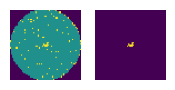

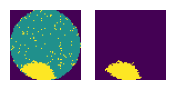

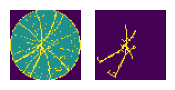

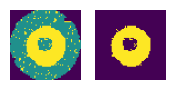

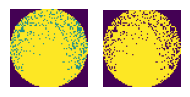

In [59]:
# TODO: Verify the salient region
# Below is an example call; you should show different wafer maps than example

failure_types = df_train["failureType"].unique()

for ftype in failure_types:
    example_row = df_train[df_train["failureType"] == ftype].iloc[2]

    wafer = example_row["waferMap_resized"]
    salient = example_row["salientRegion"]

    fig, axes = plt.subplots(1, 2, figsize=(2, 2))

    axes[0].imshow(wafer)
    #axes[0].set_title(f"{ftype} — Original")
    axes[0].axis("off")

    axes[1].imshow(salient)
    #axes[1].set_title(f"{ftype} — Salient Region")
    axes[1].axis("off")

plt.tight_layout()
plt.show()

In [60]:
# TODO: Implement a function that returns the ratio of the area of the salient region to the area of the wafer map
def get_area_ratio(row: pd.Series) -> float:
    salient = row["salientRegion"]
    wafer = row["waferMap_resized"]

    salient_area = np.sum(salient)

    total_die_area = np.sum(wafer != 0)

    if total_die_area == 0:
        return 0.0
    return  salient_area / total_die_area


In [61]:
# TODO: Implement a function that returns the ratio of the perimeter of the salient region to the radius of the wafer map
from skimage.measure import perimeter

def get_perimeter_ratio(row: pd.Series) -> float:
    
    salient = row["salientRegion"]     

    perim = perimeter(salient, neighborhood=8)

    radius = 32
    
    return perim / radius

In [62]:
# TODO: Implement a function that returns the maximal distance between the salient region and the center of the wafer map
def get_max_dist_from_center(row: pd.Series) -> float:
    salient = row["salientRegion"]        

    ys, xs = np.where(salient == 1)

    if len(xs) == 0:
        return 0.0
    
    center_y = 31.5
    center_x = 31.5

    distances = np.sqrt((xs - center_x)**2 + (ys - center_y)**2)

    return np.max(distances)


In [63]:
# TODO: Implement a function that returns the minimal distance between the salient region and the center of the wafer map
def get_min_dist_from_center(row: pd.Series) -> float:
    salient = row["salientRegion"]        

    ys, xs = np.where(salient == 1)

    if len(xs) == 0:
        return 0.0
    
    center_y = 31.5
    center_x = 31.5

    distances = np.sqrt((xs - center_x)**2 + (ys - center_y)**2)
    
    return np.min(distances)

In [64]:
# TODO: Implement a function that returns the ratio of the length of the major axis of the estimated ellipse surrounding the salient region to the radius of the wafer map

from skimage.measure import regionprops
def get_major_axis_ratio(row: pd.Series) -> float:
    salient = row["salientRegion"]

    if np.sum(salient) == 0:
        return 0.0

    props = regionprops(salient.astype(int))

    major_axis = props[0].major_axis_length
 
    return major_axis / 32

In [65]:
# TODO: Implement a function that returns the ratio of the length of the minor axis of the estimated ellipse surrounding the salient region to the radius of the wafer map
def get_minor_axis_ratio(row: pd.Series) -> float:
    
    salient = row["salientRegion"]

    if np.sum(salient) == 0:
        return 0.0

    props = regionprops(salient.astype(int))

    minor_axis = props[0].minor_axis_length
 
    return minor_axis / 32

In [66]:
# TODO: Implement a function that returns the solidity, indicating the proportion of defective dies in the estimated convex hull of the salient region
def get_solidity(row: pd.Series) -> float:
    salient = row["salientRegion"]

    if np.sum(salient) == 0:
        return 0.0

    props = regionprops(salient.astype(int))
 
    return props[0].solidity

In [67]:
# TODO: Implement a function that returns the eccentricity of the salient region
def get_eccentricity(row: pd.Series) -> float:
    salient = row["salientRegion"]

    if np.sum(salient) == 0:
        return 0.0

    props = regionprops(salient.astype(int))
 
    return props[0].eccentricity

In [68]:
# TODO: Implement a function that returns the ratio of the failed dies on the wafer map to the total number of dies on the wafer map
def get_yield_loss(row: pd.Series) -> float:
    wafer = row["waferMap_resized"]
    fail = np.sum(wafer == 2)
    total = np.sum(wafer != 0)  # only count valid die positions

    if total == 0:
        return 0.0
    return fail / total


In [69]:
# TODO: Implement a function that returns the ratio of the failed dies on the outermost two rings of the wafer map to the total number of dies on the outermost two rings of the wafer map
# Use ring_label_from_outside helper function
def get_edge_yield_loss(row: pd.Series) -> float:

    wafer = row["waferMap_resized"]

    ring_mask = ring_label_from_outside(wafer)

    ring_dies = wafer[ring_mask == 1]
    valid_dies = ring_dies[ring_dies > 0]  

    if len(valid_dies) == 0:
        return 0.0

    fail_count = np.sum(valid_dies == 2)
    total_count = len(valid_dies)

    return fail_count / total_count


# TODO: Implement a helper function that returns a numpy array highlighting the outermost two rings of the wafer map with nonzero value
def ring_label_from_outside(wafer_map: np.ndarray) -> np.ndarray:
    h, w = wafer_map.shape

    y, x = np.indices((h, w))

    dist_from_center = np.sqrt((x - 31.5)**2 + (y - 31.5)**2)

    ring_mask = (dist_from_center >= 29.5) & (dist_from_center <= 32) #29.5 looks closer to example than 30

    return ring_mask.astype(int)

In [70]:
# ==== Additional Feature Functions ====

def radial_profile_features(img: np.ndarray, n_bins: int = 5) -> list:
    """
    Compute radial failure density profile in n_bins between center and edge.
    img: waferMap_resized (64x64), values in {0,1,2}
    Returns a list of length n_bins.
    """
    h, w = img.shape
    cy, cx = (h - 1) / 2.0, (w - 1) / 2.0

    yy, xx = np.indices(img.shape)
    r = np.sqrt((yy - cy) ** 2 + (xx - cx) ** 2)
    max_r = r.max()

    if max_r == 0:
        return [0.0] * n_bins

    r_norm = r / max_r

    # consider only valid die locations (exclude NO_DIE)
    valid_mask = (img != NO_DIE)
    fail_mask = (img == FAIL)

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    feats = []
    for i in range(n_bins):
        bin_mask = (r_norm >= bins[i]) & (r_norm < bins[i + 1]) & valid_mask
        if np.any(bin_mask):
            feats.append(fail_mask[bin_mask].mean())
        else:
            feats.append(0.0)

    return feats


def angular_features(img: np.ndarray, slices: int = 16) -> list:
    """
    Compute angular failure density in 'slices' angular bins.
    img: waferMap_resized (64x64), values in {0,1,2}
    Returns a list of length 'slices'.
    """
    h, w = img.shape
    cy, cx = (h - 1) / 2.0, (w - 1) / 2.0

    yy, xx = np.indices(img.shape)
    angles = np.arctan2(yy - cy, xx - cx)  # [-pi, pi]
    angles_norm = (angles + np.pi) / (2 * np.pi)  # [0,1)

    valid_mask = (img != NO_DIE)
    fail_mask = (img == FAIL)

    feats = []
    for i in range(slices):
        low = i / slices
        high = (i + 1) / slices
        bin_mask = (angles_norm >= low) & (angles_norm < high) & valid_mask
        if np.any(bin_mask):
            feats.append(fail_mask[bin_mask].mean())
        else:
            feats.append(0.0)

    return feats


def connected_components_features(img: np.ndarray) -> list:
    """
    Compute connected component features on failing dies.
    img: waferMap_resized (64x64), values in {0,1,2}
    Returns [num_components, largest_component_ratio].
    """
    fail_mask = (img == FAIL)
    total_fails = fail_mask.sum()

    if total_fails == 0:
        return [0.0, 0.0]

    labeled = label(fail_mask, connectivity=2)
    if labeled.max() == 0:
        return [0.0, 0.0]

    # sizes of each component (ignore background at index 0)
    sizes = np.bincount(labeled.ravel())[1:]
    num_components = float(len(sizes))
    largest = float(sizes.max())
    largest_ratio = largest / float(total_fails) if total_fails > 0 else 0.0

    return [num_components, largest_ratio]


def texture_features(img: np.ndarray) -> list:
    """
    Compute GLCM-based texture features on a binary failure mask.
    img: waferMap_resized (64x64), values in {0,1,2}
    Returns [contrast, energy, homogeneity].
    """
    # binary image: 1 if FAIL, 0 otherwise
    binary = (img == FAIL).astype(np.uint8)

    # GLCM with 2 gray levels
    glcm = graycomatrix(
        binary,
        distances=[2],
        angles=[0],
        levels=2,
        symmetric=True,
        normed=True
    )

    contrast = graycoprops(glcm, 'contrast')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    return [float(contrast), float(energy), float(homogeneity)]


In [71]:
# ==== Rotation-Invariant Additional Features ====

def get_aspect_ratio(row: pd.Series) -> float:
    """Major/minor axis length ratio of salient region."""
    salient = row["salientRegion"]
    if np.sum(salient) == 0:
        return 0.0
    props = regionprops(salient.astype(int))[0]
    if props.minor_axis_length == 0:
        return 0.0
    return props.major_axis_length / props.minor_axis_length


def get_thinness_ratio(row: pd.Series) -> float:
    """Thinness = (4π * area) / perimeter^2 (higher means more circular)."""
    salient = row["salientRegion"]
    if np.sum(salient) == 0:
        return 0.0
    
    area = salient.sum()
    peri = perimeter(salient, neighborhood=8)
    
    if peri == 0:
        return 0.0
    
    return (4 * np.pi * area) / (peri ** 2)


def get_convexity_ratio(row: pd.Series) -> float:
    """Convexity = area / convex_hull_area."""
    salient = row["salientRegion"]
    if np.sum(salient) == 0:
        return 0.0
    
    props = regionprops(salient.astype(int))[0]
    if props.convex_area == 0:
        return 0.0
    
    return props.area / props.convex_area


def get_circular_variance(row: pd.Series) -> float:
    """Rotation-invariant circular variance of failure angles."""
    img = row["waferMap_resized"]
    fail_mask = (img == FAIL)
    ys, xs = np.where(fail_mask)
    
    if len(xs) == 0:
        return 0.0
    
    cy, cx = 31.5, 31.5
    angles = np.arctan2(ys - cy, xs - cx)
    
    # circular variance = 1 - R (mean resultant length)
    R = np.sqrt(np.mean(np.cos(angles))**2 + np.mean(np.sin(angles))**2)
    return float(1 - R)


def get_line_likeness(row: pd.Series) -> float:
    """
    Rotation-invariant line-likeness using PCA eigenvalue ratio.
    Close to 1 means strong linear structure (scratch).
    """
    img = row["waferMap_resized"]
    fail_mask = (img == FAIL)
    ys, xs = np.where(fail_mask)
    
    if len(xs) < 3:
        return 0.0
    
    coords = np.vstack([xs, ys]).T
    cov = np.cov(coords.T)
    eigenvals = np.linalg.eigvalsh(cov)
    if eigenvals[0] <= 0:
        return 0.0
    
    return float(eigenvals[1] / eigenvals[0])  # λ2 / λ1


In [72]:
from skimage.transform import hough_line, hough_line_peaks

def get_hough_line_strength(row: pd.Series) -> float:
    """
    Computes the number of strong line peaks in the Hough transform.
    Scratch wafers typically have 1–3 dominant peaks.
    Others have 0 or very few.
    """
    # binary fail mask
    img = (row["waferMap_resized"] == FAIL).astype(np.uint8)

    # If no failures, no line
    if img.sum() == 0:
        return 0.0

    # Hough transform
    h, theta, dist = hough_line(img)

    # Extract dominant peaks
    _, angles, _ = hough_line_peaks(h, theta, dist, num_peaks=8)

    # strength = number of detected line angles
    return float(len(angles))

def get_line_orientation_variance(row: pd.Series) -> float:
    """
    Computes variance of failure pixel angles relative to wafer center.
    Scratch wafers have low variance (aligned line).
    Random clusters have high variance.
    """
    img = (row["waferMap_resized"] == FAIL).astype(np.uint8)

    ys, xs = np.where(img == 1)

    # If too few points, not reliable
    if len(xs) < 3:
        return 0.0

    cy, cx = 31.5, 31.5

    # Compute angles [-pi, pi]
    angles = np.arctan2(ys - cy, xs - cx)

    # Circular variance:
    # Use the vector strength to avoid wrap-around issues
    R = np.sqrt(np.mean(np.cos(angles))**2 + np.mean(np.sin(angles))**2)
    circular_var = 1 - R

    return float(circular_var)


In [73]:
from skimage.transform import probabilistic_hough_line

def hough_line_features(img: np.ndarray) -> list:
    """
    Hough-transform features for detecting straight-line patterns (Scratch).
    Returns:
        [num_lines, avg_length, max_length, angle_mean, angle_std]
    """
    fail_mask = (img == FAIL).astype(np.uint8)

    # run Hough transform
    lines = probabilistic_hough_line(
        fail_mask,
        threshold=5,
        line_length=6,
        line_gap=2
    )

    if len(lines) == 0:
        return [0, 0, 0, 0, 0]

    # extract lengths + angles
    lengths = []
    angles = []

    for (p0, p1) in lines:
        dy = p1[1] - p0[1]
        dx = p1[0] - p0[0]
        length = np.sqrt(dx*dx + dy*dy)
        angle = np.arctan2(dy, dx)

        lengths.append(length)
        angles.append(angle)

    lengths = np.array(lengths)
    angles = np.array(angles)

    return [
        float(len(lengths)),               # number of detected lines
        float(lengths.mean()),             # average line length
        float(lengths.max()),              # max line length
        float(np.mean(angles)),            # mean angle
        float(np.std(angles))              # angle spread
    ]

def ring_quadrant_features(img: np.ndarray) -> list:
    """
    Failure densities in the 4 angular quadrants of the OUTER RING ONLY.
    Returns length-4 list.
    """
    # outer ring mask reuses your function
    ring_mask = ring_label_from_outside(img)
    fail_mask = (img == FAIL)

    # coordinates
    ys, xs = np.where(ring_mask == 1)

    if len(xs) == 0:
        return [0, 0, 0, 0]

    cy, cx = 31.5, 31.5
    angles = np.arctan2(ys - cy, xs - cx)  # [-pi, pi]

    # 4 quadrants
    feats = []
    for k in range(4):
        low = -np.pi + k * (np.pi/2)
        high = -np.pi + (k+1) * (np.pi/2)
        qmask = (angles >= low) & (angles < high)
        if np.any(qmask):
            feats.append(float(fail_mask[ys[qmask], xs[qmask]].mean()))
        else:
            feats.append(0.0)

    return feats

def connected_component_extended(img: np.ndarray) -> list:
    """
    Extra connected-component statistics.
    Returns: [mean_size, std_size, normalized_component_count]
    """
    fail_mask = (img == FAIL)
    total_fails = fail_mask.sum()

    if total_fails == 0:
        return [0, 0, 0]

    labeled = label(fail_mask, connectivity=2)
    comp_sizes = np.bincount(labeled.ravel())[1:]

    if len(comp_sizes) == 0:
        return [0, 0, 0]

    mean_sz = float(comp_sizes.mean())
    std_sz = float(comp_sizes.std())
    norm_count = float(len(comp_sizes)) / float(total_fails)

    return [mean_sz, std_sz, norm_count]


In [74]:
def quadrant_failure_ratios(img: np.ndarray) -> list:
    """
    Returns fail ratios in 4 quadrants:
    Q1 | Q2
    ----+----
    Q3 | Q4
    """
    h, w = img.shape
    mid_y, mid_x = h // 2, w // 2

    fail = (img == FAIL).astype(int)
    valid = (img != NO_DIE).astype(int)

    Q1 = fail[:mid_y, :mid_x].sum() / max(1, valid[:mid_y, :mid_x].sum())
    Q2 = fail[:mid_y, mid_x:].sum() / max(1, valid[:mid_y, mid_x:].sum())
    Q3 = fail[mid_y:, :mid_x].sum() / max(1, valid[mid_y:, :mid_x].sum())
    Q4 = fail[mid_y:, mid_x:].sum() / max(1, valid[mid_y:, mid_x:].sum())

    return [Q1, Q2, Q3, Q4]

def radial_slope(radials: list) -> float:
    """Simple slope: outer - inner."""
    return float(radials[-1] - radials[0])

def radial_curvature(radials: list) -> float:
    """Second difference: r4 - 2*r2 + r0."""
    if len(radials) < 5:
        return 0.0
    return float(radials[4] - 2*radials[2] + radials[0])
def get_elongation(row: pd.Series) -> float:
    salient = row["salientRegion"]
    if salient.sum() == 0:
        return 0.0
    
    props = regionprops(salient.astype(int))[0]
    minor = props.minor_axis_length
    major = props.major_axis_length
    
    if minor == 0:
        return 0.0
    return float(major / minor)

def quadrant_component_counts(img: np.ndarray) -> list:
    fail = (img == FAIL).astype(int)
    h, w = img.shape
    mid_y, mid_x = h // 2, w // 2

    def count_comp(region):
        lab = label(region, connectivity=2)
        return int(lab.max())

    Q1 = count_comp(fail[:mid_y, :mid_x])
    Q2 = count_comp(fail[:mid_y, mid_x:])
    Q3 = count_comp(fail[mid_y:, :mid_x])
    Q4 = count_comp(fail[mid_y:, mid_x:])

    return [Q1, Q2, Q3, Q4]


In [75]:
def create_feature_columns(df: pd.DataFrame) -> pd.DataFrame:

    # ===== Existing Features =====
    df['areaRatio'] = df.apply(get_area_ratio, axis=1)
    df['perimeterRatio'] = df.apply(get_perimeter_ratio, axis=1)
    df['maxDistFromCenter'] = df.apply(get_max_dist_from_center, axis=1)
    df['minDistFromCenter'] = df.apply(get_min_dist_from_center, axis=1)
    df['majorAxisRatio'] = df.apply(get_major_axis_ratio, axis=1)
    df['minorAxisRatio'] = df.apply(get_minor_axis_ratio, axis=1)
    df['solidity'] = df.apply(get_solidity, axis=1)
    df['eccentricity'] = df.apply(get_eccentricity, axis=1)
    df['yieldLoss'] = df.apply(get_yield_loss, axis=1)
    df['edgeYieldLoss'] = df.apply(get_edge_yield_loss, axis=1)

    # ===== NEW FEATURES: Radial Profile (5 bins) =====
    radial_df = df['waferMap_resized'].apply(lambda img: pd.Series(
        radial_profile_features(img),
        index=[f"radial_{i}" for i in range(5)]
    ))
    df = pd.concat([df, radial_df], axis=1)

    # ===== NEW FEATURES: Angular Histogram (8 bins) =====
    ang_df = df['waferMap_resized'].apply(lambda img: pd.Series(
        angular_features(img),
        index=[f"ang_{i}" for i in range(16)]
    ))
    df = pd.concat([df, ang_df], axis=1)

    # ===== NEW FEATURES: Connected Components (2) =====
    comp_df = df['waferMap_resized'].apply(lambda img: pd.Series(
        connected_components_features(img),
        index=["numComponents", "largestComponentRatio"]
    ))
    df = pd.concat([df, comp_df], axis=1)

    # ===== NEW FEATURES: GLCM Texture (3) =====
    glcm_df = df['waferMap_resized'].apply(lambda img: pd.Series(
        texture_features(img),
        index=["glcm_contrast", "glcm_energy", "glcm_homogeneity"]
    ))
    df = pd.concat([df, glcm_df], axis=1)

    # ===== NEW FEATURES: Rotation-Invariant Shape Measures (5) =====
    df['aspectRatio']       = df.apply(get_aspect_ratio, axis=1)
    df['thinnessRatio']     = df.apply(get_thinness_ratio, axis=1)
    df['convexityRatio']    = df.apply(get_convexity_ratio, axis=1)
    df['circularVariance']  = df.apply(get_circular_variance, axis=1)
    df['lineLikeness']      = df.apply(get_line_likeness, axis=1)

        # ===== ADD HOUGH + ANGLE VARIANCE HERE =====
    df['houghLineStrength'] = df.apply(get_hough_line_strength, axis=1)
    df['lineOrientationVariance'] = df.apply(get_line_orientation_variance, axis=1)

    hough_df = df['waferMap_resized'].apply(lambda img: pd.Series(
        hough_line_features(img),
        index=["hough_num", "hough_avg_len", "hough_max_len", "hough_angle_mean", "hough_angle_std"]
    ))
    df = pd.concat([df, hough_df], axis=1)

    # ===== Outer Ring Quadrant Failure Density (4) =====
    ringq_df = df['waferMap_resized'].apply(lambda img: pd.Series(
        ring_quadrant_features(img),
        index=["ringQ1", "ringQ2", "ringQ3", "ringQ4"]
    ))
    df = pd.concat([df, ringq_df], axis=1)

    # ===== Extended Connected Component Stats (3) =====
    comp_ext_df = df['waferMap_resized'].apply(lambda img: pd.Series(
        connected_component_extended(img),
        index=["comp_mean_size", "comp_std_size", "comp_norm_count"]
    ))
    df = pd.concat([df, comp_ext_df], axis=1)

    # ==== NEW FEATURES ONLY ====

    # 1. Radial Slope + Curvature
    df["radialSlope"] = radial_df.apply(lambda x: radial_slope(list(x.values)), axis=1)
    df["radialCurvature"] = radial_df.apply(lambda x: radial_curvature(list(x.values)), axis=1)

    # 2. Quadrant Failure Ratios (4 features)
    quad_fail_df = df['waferMap_resized'].apply(
        lambda img: pd.Series(
            quadrant_failure_ratios(img),
            index=["quadFail_Q1", "quadFail_Q2", "quadFail_Q3", "quadFail_Q4"]
        )
    )
    df = pd.concat([df, quad_fail_df], axis=1)

    # 3. Quadrant Component Counts (4 features)
    quad_comp_df = df['waferMap_resized'].apply(
        lambda img: pd.Series(
            quadrant_component_counts(img),
            index=["quadComp_Q1", "quadComp_Q2", "quadComp_Q3", "quadComp_Q4"]
        )
    )
    df = pd.concat([df, quad_comp_df], axis=1)

    # 4. Elongation (major/minor axis)
    df["elongation"] = df.apply(get_elongation, axis=1)


    return df




In [76]:
from skimage.transform import rotate

# ---------------------------------------------
# Helper: Generate augmented versions of an image
# ---------------------------------------------
def augment_image(img):
    """Return list of augmented images (NO FEATURE COMPUTATION HERE)."""
    aug = [
        np.rot90(img, 1),
        np.rot90(img, 2),
        np.rot90(img, 3),
        np.flipud(img),
        np.fliplr(img),
        rotate(img, angle=np.random.uniform(-10, 10), order=0,
               preserve_range=True).astype(img.dtype)
    ]
    return aug


# -------------------------------------------------------------
# Augment training data BEFORE feature creation (correct way!)
# -------------------------------------------------------------
def prepare_augmented_data(df: pd.DataFrame, min_samples: int = 200) -> pd.DataFrame:
    """
    Augments underrepresented classes to reach at least min_samples.
    Only modifies waferMap + waferMap_resized + failureType_num.
    Does NOT compute features — feature extraction happens later.
    """
    print("=== Running data augmentation BEFORE feature creation ===")

    # Add flag if missing
    if "isAugmented" not in df.columns:
        df["isAugmented"] = False

    # Count per class
    total_counts = df["failureType"].value_counts()
    print("Current total counts:")
    print(total_counts)

    # Identify classes that need augmentation
    minority_classes = [cls for cls, cnt in total_counts.items() if cnt < min_samples]
    print("Classes needing augmentation:", minority_classes)

    augmented_rows = []

    for cls in minority_classes:
        current_total = total_counts[cls]
        needed = min_samples - current_total

        print(f"Augmenting '{cls}' → need {needed} samples")

        # Only original rows should be augmented
        originals = df[(df["failureType"] == cls) & (df["isAugmented"] == False)]

        for _, row in originals.iterrows():
            if needed <= 0:
                break

            # Make augmented versions of this wafer
            for img_aug in augment_image(row["waferMap"]):
                if needed <= 0:
                    break

                new_row = row.copy()

                # Replace only the image + resized image
                new_row["waferMap"] = img_aug
                new_row["waferMap_resized"] = resize_wafer_map(img_aug)

                # Copy numeric label
                new_row["failureType_num"] = convert_failure_type(new_row["failureType"])

                # Mark as augmented
                new_row["isAugmented"] = True

                augmented_rows.append(new_row)
                needed -= 1

    # Append new rows
    if augmented_rows:
        df_aug = pd.DataFrame(augmented_rows)
        df = pd.concat([df, df_aug], ignore_index=True)

    print("New total training size:", len(df))
    print("Counts after augmentation:")
    print(df["failureType"].value_counts())

    return df


In [77]:
#df_train = prepare_augmented_data(df_train)     # augment first

df_train["salientRegion"] = df_train.apply(get_salient_region, axis=1)
df_train = create_feature_columns(df_train)     # THEN compute features


In [78]:
from sklearn.base import BaseEstimator, ClassifierMixin
from xgboost import XGBClassifier

class XGBWithEarlyStopping(BaseEstimator, ClassifierMixin):
    def __init__(self, **params):
        self.params = params
        self.estimator = XGBClassifier(
            **{k: v for k, v in params.items() if k != "early_stopping_rounds"},
            eval_metric="mlogloss",
            tree_method="hist",
            objective="multi:softprob"
        )
        self.early_stopping_rounds = params.get("early_stopping_rounds", 20)

    def fit(self, X, y):
        # Build a validation set using 20% split INSIDE each CV fold
        from sklearn.model_selection import train_test_split
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        self.estimator.set_params(**{k: v for k, v in self.params.items() if k != "early_stopping_rounds"})
        
        self.estimator.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=self.early_stopping_rounds,
            verbose=False
        )
        return self

    def predict(self, X):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)


In [79]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.neural_network import MLPClassifier
# from xgboost import XGBClassifier
# import numpy as np

# from xgboost.callback import EarlyStopping


# def run_model_grid_search(X, y):

#     print("=== Starting Multi-Model Grid Search ===")

#     models_and_grids = {

#         # ---------------------------
#         # 1. SVM (RBF)
#         # ---------------------------
#         "SVM_RBF": (
#             SVC(probability=False),
#             {
#                 "kernel": ["rbf"],
#                 "C": [0.1, 1, 10, 50],
#                 "gamma": ["scale", 0.3, 0.1, 0.01, 0.001]
#             }
#         ),

#         # ---------------------------
#         # 2. RandomForest
#         # ---------------------------
#         "RandomForest": (
#             RandomForestClassifier(),
#             {
#                 "n_estimators": [100, 200, 400],
#                 "max_depth": [5, 10, 20],
#                 "min_samples_split": [2, 5],
#                 "min_samples_leaf": [1, 2]
#             }
#         ),

#         # ---------------------------
#         # 3. XGBoost  (with regularization!)
#         # ---------------------------
#         "XGBoost": (
#             XGBClassifier(
                
#                 eval_metric="mlogloss",
#                 tree_method="hist",
#                 objective="multi:softprob"
        
#             ),
        
#             {
#                 # # Core parameters
#                 # "n_estimators": [200, 350],                # moderate + slightly larger
#                 # "learning_rate": [0.05, 0.1],             # stable + slightly faster
#                 # "max_depth": [3, 6, 9],                   # shallow / medium / deep

#                 # # Sampling parameters (diverse but small grid)
#                 # "subsample": [0.8, 1.0],
#                 # "colsample_bytree": [0.8, 1.0],

#                 # # Regularization parameters (kept small but meaningful)
#                 # "min_child_weight": [1, 4],               # low + medium
#                 # "gamma": [0, 0.2],                        # no pruning vs light pruning
#                 # "reg_alpha": [0, 0.5],                    # L1 penalty: off / light
#                 # "reg_lambda": [1.0]                       # fix L2 penalty to reduce grid

              
#                 "n_estimators": [350, 500],
#                 "max_depth": [3, 5, 7, 9],
#                 "learning_rate": [0.05, 0.1],

#                 "subsample": [0.7, 0.8, 0.9, 1.0],
#                 "colsample_bytree": [0.7, 0.8, 0.9, 1.0],

#                 "min_child_weight": [1, 3, 5, 8],
#                 "gamma": [0, 0.1, 0.3, 0.5],

#                 "reg_alpha": [0, 0.1, 0.5, 1.0],
#                 "reg_lambda": [0.5, 1.0, 2.0],

#                 "grow_policy": ["depthwise", "lossguide"],
#                 "max_leaves": [31, 63],     # only used if lossguide

#                 "max_bin": [128, 256],


#             }
#         ),


#         # ---------------------------
#         # 4. Logistic Regression
#         # ---------------------------
#         "LogisticRegression": (
#             LogisticRegression(max_iter=500, multi_class="auto"),
#             {
#                 "C": [0.1, 1, 5, 10],
#                 "penalty": ["l2"]
#             }
#         ),

#         # ---------------------------
#         # 5. MLP Neural Network
#         # ---------------------------
#         "MLP": (
#             MLPClassifier(max_iter=300),
#             {
#                 "hidden_layer_sizes": [(64,), (128,), (128, 64)],
#                 "learning_rate_init": [0.001, 0.01],
#                 "alpha": [0.0001, 0.001]
#             }
#         ),
#     }

#     best_model = None
#     best_score = -1
#     best_name = None
#     best_params = None

#     for name, (model, grid) in models_and_grids.items():
#         print(f"\n=== Searching {name} ===")
#         gs = GridSearchCV(
#             model,
#             grid,
#             cv=5,
#             scoring="accuracy",
#             n_jobs=-1
#         )
#         gs.fit(X, y)

#         print(f"> Best {name} validation accuracy: {gs.best_score_:.4f}")
#         print(f"> Best hyperparameters: {gs.best_params_}")

#         if name == "XGBoost": #gs.best_score_ > best_score: #testing
#             best_score = gs.best_score_
#             best_model = gs.best_estimator_
#             best_name = name
#             best_params = gs.best_params_

#     print("\n========================================")
#     print(" BEST OVERALL MODEL FOUND ")
#     print("========================================")
#     print(f"Model: {best_name}")
#     print(f"Validation Accuracy: {best_score:.4f}")
#     print(f"Params: {best_params}")

#     return best_model, best_name, best_score, best_params


In [80]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


def run_model_grid_search(X, y):

    print("=== Starting FAST Multi-Model Grid Search (≈30 minutes max) ===")

    models_and_grids = {

        # ------------------------------------------------------------
        # 1. FAST SVM (small grid)
        # ------------------------------------------------------------
        "SVM_RBF": (
            SVC(),
            {
                "C": [1, 10],
                "gamma": ["scale", 0.01],
                "kernel": ["rbf"]
            }
        ),

        # ------------------------------------------------------------
        # 2. Tiny RandomForest
        # ------------------------------------------------------------
        "RandomForest": (
            RandomForestClassifier(),
            {
                "n_estimators": [200],
                "max_depth": [10, None],
                "min_samples_split": [2],
            }
        ),

        # ------------------------------------------------------------
        # 3. XGBoost (slimmed grid)
        # ------------------------------------------------------------
        "XGBoost": (
            XGBClassifier(
                eval_metric="mlogloss",
                tree_method="hist",
                objective="multi:softprob",
                use_label_encoder=False,
            ),
            {
                "n_estimators": [350],
                "max_depth": [4, 6, 9],
                "learning_rate": [0.1],
                "subsample": [0.8, 1.0],
                "colsample_bytree": [0.8, 1.0],
                "gamma": [0, 0.2],
                "min_child_weight": [1, 3],
                "reg_alpha": [0, 0.1],
                "reg_lambda": [0.5, 1.0],
            }
        ),

        # ------------------------------------------------------------
        # 4. LightGBM (fast + strong)
        # ------------------------------------------------------------
        "LightGBM": (
            LGBMClassifier(
                objective="multiclass",
                verbosity=-1        # <-- suppresses LightGBM warnings!
            ),
            {
                "n_estimators": [400, 600],
                "learning_rate": [0.05],
                "max_depth": [-1, 6],
                "num_leaves": [31, 63],
                "subsample": [0.8, 1.0],
                "colsample_bytree": [0.8, 1.0],
            }
        ),
    }


    best_model = None
    best_score = -1
    best_name = None
    best_params = None

    # ------------------------------------------------------------
    # MODEL SEARCH LOOP
    # ------------------------------------------------------------
    for name, (model, grid) in models_and_grids.items():
        print(f"\n=== Searching {name} (Reduced Grid) ===")

        gs = GridSearchCV(
            model,
            grid,
            cv=3,                 # ← makes everything 40–50% faster
            scoring="accuracy",
            n_jobs=-1
        )
        gs.fit(X, y)

        print(f"> Best {name} accuracy: {gs.best_score_:.4f}")
        print(f"> Best params: {gs.best_params_}")

        if gs.best_score_ > best_score:
            best_score = gs.best_score_
            best_model = gs.best_estimator_
            best_name = name
            best_params = gs.best_params_

    # ------------------------------------------------------------
    # PRINT RESULTS
    # ------------------------------------------------------------
    print("\n========================================")
    print(" BEST OVERALL MODEL FOUND (FAST SEARCH)")
    print("========================================")
    print(f"Model: {best_name}")
    print(f"Accuracy: {best_score:.4f}")
    print(f"Params: {best_params}")

    return best_model, best_name, best_score, best_params


In [81]:
# ============================================================
# === FEATURE SELECTION + SMOTE + TRAIN/VALID SPLIT (CLEAN) ===
# ============================================================

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd

# ------------------------------------------------------------
# 1. Select usable feature columns
# ------------------------------------------------------------
feature_cols = [
    c for c in df_train.columns
    if c not in (
        "waferMap", "waferMap_resized", "salientRegion",
        "failureType", "failureType_num", "dieSize",
        "lotName", "trainTestLabel", "waferIndex", "isAugmented"
    )
]

print(f"Number of features used: {len(feature_cols)}")

# ------------------------------------------------------------
# 2. Extract X, y
# ------------------------------------------------------------
X = df_train[feature_cols].values
y = df_train["failureType_num"].values

print("Original class counts:", np.bincount(y))

# ------------------------------------------------------------
# 3. Apply SMOTE ONLY to minority class (Near-full = class 3)
# ------------------------------------------------------------
target_samples = 400
sampling_strategy = {3: target_samples}   # only boost Near-full

# sm = SMOTE(
#     sampling_strategy=sampling_strategy,
#     k_neighbors=3,
#     random_state=RANDOM_SEED
# )

# ------------------------------------------------------------
# 2.5 Handle missing values BEFORE SMOTE
# ------------------------------------------------------------
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)

# (Optional sanity check)
print("Remaining NaNs:", np.isnan(X).sum())


#X_resampled, y_resampled = sm.fit_resample(X, y)

X_resampled, y_resampled = X, y # Skip SMOTE for faster testing

print("After SMOTE:", np.bincount(y_resampled))

# ------------------------------------------------------------
# 4. Train/Validation split (BEFORE SCALING — correct method)
# ------------------------------------------------------------
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y_resampled
)

# ------------------------------------------------------------
# 5. Standardization (fit ONLY on training → no leakage)
# ------------------------------------------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)

print("\nTraining distribution:")
print(pd.Series(y_train).value_counts())

print("\nValidation distribution:")
print(pd.Series(y_valid).value_counts())

# ------------------------------------------------------------
# 6. GRID SEARCH USING PROPERLY SCALED TRAIN SET
# ------------------------------------------------------------
best_model, best_name, best_score, best_params = run_model_grid_search(
    X_train, y_train
)

# ------------------------------------------------------------
# 7. REFIT BEST MODEL ON FULL (RESAMPLED + SCALED) DATA
# ------------------------------------------------------------
# Scale the full resampled dataset using the SAME scaler
#X_resampled = scaler.transform(X_resampled)
X_resampled = scaler.transform(X_resampled) #no SMOTE

#best_model.fit(X_resampled, y_resampled)


print("\n=== FINAL MODEL FIT COMPLETE ===")
print(f"Best model: {best_name}")
print(f"Best score: {best_score:.4f}")
print(f"Best params: {best_params}")


Number of features used: 66
Original class counts: [ 771  388 1159   15  413]
Remaining NaNs: 0
After SMOTE: [ 771  388 1159   15  413]

Training distribution:
2    927
0    617
4    330
1    310
3     12
Name: count, dtype: int64

Validation distribution:
2    232
0    154
4     83
1     78
3      3
Name: count, dtype: int64
=== Starting FAST Multi-Model Grid Search (≈30 minutes max) ===

=== Searching SVM_RBF (Reduced Grid) ===
> Best SVM_RBF accuracy: 0.9818
> Best params: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

=== Searching RandomForest (Reduced Grid) ===
> Best RandomForest accuracy: 0.9745
> Best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

=== Searching XGBoost (Reduced Grid) ===
> Best XGBoost accuracy: 0.9795
> Best params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 350, 'reg_alpha': 0, 'reg_lambda': 0.5, 'subsample': 0.8}

=== Searching LightGBM (Reduced Grid) ===
> Best L

In [82]:
# TODO: check train/validation distribution

train_counts = pd.Series(y_train).value_counts().sort_index()
valid_counts = pd.Series(y_valid).value_counts().sort_index()

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_valid.shape)

print("\nTraining distribution:")
print(train_counts)

print("\nValidation distribution:")
print(valid_counts)

# plt.figure(figsize=(10,5))
# plt.bar(train_counts.index - 0.2, train_counts.values, width=0.4, label='Train')
# plt.bar(valid_counts.index + 0.2, valid_counts.values, width=0.4, label='Validation')
# plt.xlabel("Failure Type (numeric label)")
# plt.ylabel("Count")
# plt.title("Class Distribution in Train vs Validation Split")
# plt.legend()
# plt.show()

Training set shape: (2196, 66)
Validation set shape: (550, 66)

Training distribution:
0    617
1    310
2    927
3     12
4    330
Name: count, dtype: int64

Validation distribution:
0    154
1     78
2    232
3      3
4     83
Name: count, dtype: int64


In [83]:
# TODO: Make a dictionary that is the reverse of the string2int mapping defined above.
int2string = {
    0: 'Center',
    1: 'Donut',
    2: 'Edge-Loc',
    3: 'Near-full',
    4: 'Scratch'
}

In [84]:
# === 1. Load test ===
data_test = np.load("data/wafermap_test.npy", allow_pickle=True)
df_test = pd.DataFrame({name: data_test[name] for name in data_test.dtype.names})

# === 2. Prepare test (resize only) ===
df_test, _ = prepare_data(df_test, has_labels=False)

# === 3. Salient region ===
df_test["salientRegion"] = df_test.apply(get_salient_region, axis=1)

# === 4. Create ALL features (MUST BE BEFORE BUILDING feature_cols list) ===
df_test = create_feature_columns(df_test)


print("Features from training:", len(feature_cols))
print("df_test has:", sum(c in df_test.columns for c in feature_cols), "matching columns")

# === 6. Build X_test using VERIFIED columns ===
#X_test = df_test[feature_cols].values


Features from training: 66
df_test has: 66 matching columns


In [85]:
missing_in_test = [c for c in feature_cols if c not in df_test.columns]
print("missing in test:", missing_in_test)

print(len(feature_cols))
print(df_test.columns.size)
#df_test = create_feature_columns(df_test)


missing in test: []
66
73


In [86]:
from sklearn.metrics import confusion_matrix

# Validation predictions using the best model BEFORE refitting on full data
y_pred_valid = best_model.predict(X_valid)

# Confusion matrix
cm = confusion_matrix(y_valid, y_pred_valid)

print("\n=== Per-Class Accuracy (Validation Set) ===")
for label in range(len(int2string)):
    correct = cm[label, label]
    total = cm[label].sum()
    acc = correct / total if total > 0 else 0
    print(f"{int2string[label]:<10} : {acc:.4f} ({correct}/{total})")



=== Per-Class Accuracy (Validation Set) ===
Center     : 0.9870 (152/154)
Donut      : 0.9487 (74/78)
Edge-Loc   : 0.9957 (231/232)
Near-full  : 1.0000 (3/3)
Scratch    : 0.9518 (79/83)


In [87]:
import numpy as np
import pandas as pd

if best_name == "XGBoost":
    importances = best_model.feature_importances_
    feat_imp = pd.Series(importances, index=feature_cols).sort_values(ascending=False)
    print(feat_imp.head(20))
    print(feat_imp.tail(20))

In [88]:
# ============================================================
# === REMOVE LOW-IMPORTANCE FEATURES BEFORE FINAL TRAINING ===
# ============================================================

print("\n=== Selecting features by importance ===")

# 1. Get importances from the best model chosen by grid search
if best_name == "XGBoost":
    importances = best_model.feature_importances_

    # 2. Threshold — tuneable (0.003 is good for your dataset)
    THRESH = 0.003

    # 3. Build list of important features
    important_mask = importances >= THRESH
    important_features = [
        f for f, keep in zip(feature_cols, important_mask) if keep
    ]

    print(f"Total features before: {len(feature_cols)}")
    print(f"Total features kept:   {len(important_features)}")
    print("Kept features:")
    print(important_features)

    # 4. Rebuild X and y using ONLY important features
    X = df_train[important_features].values
    y = df_train["failureType_num"].values

    # 5. Reapply imputer (IMPORTANT — do not reuse old one)
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy="mean")
    X = imputer.fit_transform(X)
else:
    print("No feature selection for non-XGBoost models.")
    important_features = feature_cols  # keep all features
    X = df_train[important_features].values
    y = df_train["failureType_num"].values

# 6. Re-do train/validation split
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y
)

# 7. Re-fit scaler ONLY on training set (NO LEAKAGE)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)

print("\nShapes after feature selection:")
print("X_train:", X_train.shape)
print("X_valid:", X_valid.shape)

# 8. Refit the model with early stopping using the selected features
if best_name == "XGBoost":
    best_model.set_params(
        early_stopping_rounds=20,
        eval_metric="mlogloss"
    )
    print("Refitting XGBoost with early stopping on selected features...")
    best_model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )
else:
    best_model.fit(X_train, y_train)

# 9. Evaluate again
from sklearn.metrics import confusion_matrix

y_pred_valid = best_model.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred_valid)

print("\n=== Per-Class Accuracy (AFTER Feature Selection) ===")
for cls_id in range(len(int2string)):
    correct = cm[cls_id, cls_id]
    total = cm[cls_id].sum()
    acc = correct / total if total else 0
    print(f"{int2string[cls_id]:<10} : {acc:.4f} ({correct}/{total})")

print(f"Total validation accuracy: {np.trace(cm) / np.sum(cm):.4f}")
# ============================================================
# === 10. REBUILD TEST DATA USING SAME FEATURE SELECTION ===
# ============================================================

X_test = df_test[important_features].values
X_test = imputer.transform(X_test)
X_test_scaled = scaler.transform(X_test)

pred_test = best_model.predict(X_test_scaled)

pred_labels = [int2string[i] for i in pred_test]
pd.DataFrame({"failureType": pred_labels}).to_csv("scores.csv", index=False)
print("scores.csv saved with selected features!")



=== Selecting features by importance ===
No feature selection for non-XGBoost models.

Shapes after feature selection:
X_train: (2196, 66)
X_valid: (550, 66)

=== Per-Class Accuracy (AFTER Feature Selection) ===
Center     : 0.9870 (152/154)
Donut      : 0.9487 (74/78)
Edge-Loc   : 0.9957 (231/232)
Near-full  : 1.0000 (3/3)
Scratch    : 0.9518 (79/83)
Total validation accuracy: 0.9800
scores.csv saved with selected features!


In [89]:
def compare_line_by_line(file1, file2):
    with open(file1, 'r') as f1:
        lines1 = f1.readlines()
    with open(file2, 'r') as f2:
        lines2 = f2.readlines()


    if len(lines1) != len(lines2):
        print(f"Warning: Files have different number of lines ({len(lines1)} vs {len(lines2)})")

    if len(lines1) != 2027 or len(lines2) != 2027:
        print("Warning: One or both files do not have 2028 lines as expected.")
        
    matches = 0
    for i in range(2027):
        line1 = lines1[i].strip() 
        line2 = lines2[i].strip()

        if line1 == line2:
            matches += 1

    similarity = (matches / 2027) * 100

    return similarity


# Example usage:
acc = compare_line_by_line("scores.csv", "dt_scores.csv")
print(f"Accuracy compared with Tree: {acc:.2f}%") #should be around 81%

acc = compare_line_by_line("scores.csv", "svc_scores.csv")
print(f"Accuracy compared with SVC: {acc:.2f}%") #should be around 90.23%


Accuracy compared with Tree: 82.68%
Accuracy compared with SVC: 91.47%


In [90]:
acc = compare_line_by_line("scores_sub.csv", "dt_scores.csv")
print(f"Accuracy compared with Tree: {acc:.2f}%") #should be around 81%

acc = compare_line_by_line("scores_sub.csv", "svc_scores.csv")
print(f"Accuracy compared with SVC: {acc:.2f}%") #should be around 90.23%

Accuracy compared with Tree: 83.72%
Accuracy compared with SVC: 91.66%


In [91]:
acc = compare_line_by_line("scores_sub.csv", "scores.csv")
print(f"Accuracy compared with other model: {acc:.2f}%") #should be around 90.23%

Accuracy compared with other model: 95.51%


In [92]:
# ============================================================
# 0. IMPORTS (FIXED)
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

import lightgbm as lgb
from lightgbm import LGBMClassifier


In [93]:
def tune_lgbm(X_train, y_train):
    print("\n============================")
    print("  Randomized Search — LightGBM")
    print("============================")

    lgbm = LGBMClassifier(
        objective="multiclass",
        n_jobs=-1,
        verbosity=-1
    )

    param_dist = {
        "n_estimators": [300, 500, 700, 900],
        "learning_rate": [0.03, 0.05, 0.07, 0.1],
        "num_leaves": [31, 63, 127, 255],
        "max_depth": [-1, 5, 7, 10],
        "min_child_samples": [10, 20, 40],
        "subsample": [0.7, 0.8, 0.9, 1.0],
        "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
        "reg_alpha": [0, 0.1, 0.5, 1.0],
        "reg_lambda": [0.5, 1.0, 2.0],
        "min_split_gain": [0.0, 0.1, 0.3],
    }

    rs = RandomizedSearchCV(
        estimator=lgbm,
        param_distributions=param_dist,
        n_iter=40,                 # ~15 minutes
        scoring="accuracy",
        cv=3,
        verbose=1,
        n_jobs=-1,
        random_state=10
    )

    rs.fit(X_train, y_train)

    print("\nBest LightGBM params:")
    print(rs.best_params_)
    print(f"Validation Accuracy: {rs.best_score_:.4f}")

    best_lgbm = rs.best_estimator_
    return best_lgbm, rs.best_params_, rs.best_score_


In [94]:
best_lgbm, best_params, best_cv_score = tune_lgbm(X_train, y_train)

print("\n=== Training best LightGBM on FULL TRAIN SET ===")
best_lgbm.fit(X_train, y_train)

# Validation accuracy
y_pred_valid = best_lgbm.predict(X_valid)
valid_acc = accuracy_score(y_valid, y_pred_valid)
print(f"\nValidation Accuracy (Full Model): {valid_acc:.4f}")

# Test prediction
try:
    y_pred_test = best_lgbm.predict(X_test_scaled)
    df_test["pred_full"] = [int2string[i] for i in y_pred_test]
    print("\nTest predictions saved in df_test['pred_full']")
except Exception as e:
    print("Test set prediction failed:", e)



  Randomized Search — LightGBM
Fitting 3 folds for each of 40 candidates, totalling 120 fits

Best LightGBM params:
{'subsample': 1.0, 'reg_lambda': 0.5, 'reg_alpha': 0, 'num_leaves': 63, 'n_estimators': 900, 'min_split_gain': 0.0, 'min_child_samples': 40, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Validation Accuracy: 0.9800

=== Training best LightGBM on FULL TRAIN SET ===

Validation Accuracy (Full Model): 0.9727

Test predictions saved in df_test['pred_full']


In [95]:
# ============================================================
# 3. FEATURE PRUNING BASED ON THRESHOLD
# ============================================================

importances = best_lgbm.feature_importances_
feat_imp = pd.Series(importances, index=feature_cols).sort_values(ascending=False)

print("\n=== LIGHTGBM FEATURE IMPORTANCES ===")
print(feat_imp)

# ----------- SET YOUR THRESHOLD HERE -----------
lgbm_thresh = 5     # Recommended: 3–10 depending on aggressiveness
# ----------------------------------------------

# Keep features whose importance is >= threshold
kept_features = feat_imp[feat_imp >= lgbm_thresh].index.tolist()

print(f"\nUsing LightGBM importance threshold = {lgbm_thresh}")
print(f"Keeping {len(kept_features)}/{len(feat_imp)} features")
print("Kept features:", kept_features)

# Convert feature names → indices in original feature_cols
idxs = [feature_cols.index(f) for f in kept_features]

# Build reduced datasets
X_train_red = X_train_raw[:, idxs]
X_valid_red = X_valid_raw[:, idxs]
X_test_red = X_test_scaled[:, idxs]



=== LIGHTGBM FEATURE IMPORTANCES ===
maxDistFromCenter          2389
minDistFromCenter          2019
circularVariance           2003
solidity                   1966
eccentricity               1707
                           ... 
comp_norm_count              58
radial_4                      0
lineOrientationVariance       0
convexityRatio                0
elongation                    0
Length: 66, dtype: int32

Using LightGBM importance threshold = 5
Keeping 62/66 features
Kept features: ['maxDistFromCenter', 'minDistFromCenter', 'circularVariance', 'solidity', 'eccentricity', 'radial_0', 'radial_1', 'radial_3', 'ang_4', 'hough_angle_mean', 'ringQ3', 'radialCurvature', 'thinnessRatio', 'ringQ1', 'largestComponentRatio', 'lineLikeness', 'hough_angle_std', 'hough_avg_len', 'ringQ2', 'ringQ4', 'edgeYieldLoss', 'ang_15', 'ang_8', 'ang_0', 'ang_11', 'hough_max_len', 'houghLineStrength', 'ang_3', 'quadComp_Q1', 'glcm_contrast', 'quadComp_Q3', 'hough_num', 'glcm_energy', 'quadComp_Q2', 'ang_

In [98]:
# ============================================================
# 4. TRAIN LightGBM ON REDUCED FEATURE SET
# ============================================================

print("\n=== Training LightGBM on Reduced Feature Set (Threshold) ===")

reduced_lgbm = LGBMClassifier(
    **best_params,
    objective="multiclass",
    n_jobs=-1,
    verbosity=-1
)

reduced_lgbm.fit(X_train_red, y_train)

# Validation accuracy (reduced feature model)
y_pred_valid_red = reduced_lgbm.predict(X_valid_red)
valid_acc_red = accuracy_score(y_valid, y_pred_valid_red)

print("\n=== LightGBM Validation Accuracies ===")
print(f"Full features:    {valid_acc:.4f}")
print(f"Reduced features: {valid_acc_red:.4f}")
print("=======================================\n")

# Optional test predictions
try:
    y_pred_test_red = reduced_lgbm.predict(X_test_red)
    df_test["pred_lgbm_reduced"] = [int2string[i] for i in y_pred_test_red]
except:
    pass



=== Training LightGBM on Reduced Feature Set (Threshold) ===

=== LightGBM Validation Accuracies ===
Full features:    0.9727
Reduced features: 0.9727



In [99]:
print("\n====================================")
print("     FINAL MODEL COMPARISON")
print("====================================")
print(f"Full LightGBM Validation Accuracy:     {valid_acc:.4f}")
print(f"Reduced-Feature LightGBM Accuracy:     {valid_acc_red:.4f}")
print("====================================")
print("Difference:", valid_acc - valid_acc_red)



     FINAL MODEL COMPARISON
Full LightGBM Validation Accuracy:     0.9727
Reduced-Feature LightGBM Accuracy:     0.9727
Difference: 0.0


In [100]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

def tune_xgb(X_train, y_train):
    print("\n============================")
    print("  Randomized Search — XGBoost")
    print("============================")

    xgb = XGBClassifier(
        objective="multi:softprob",
        eval_metric="mlogloss",
        tree_method="hist",
        use_label_encoder=False,
        n_jobs=-1
    )

    param_dist = {
        "n_estimators": [300, 400, 500, 700],
        "learning_rate": [0.03, 0.05, 0.07, 0.1],
        "max_depth": [3, 4, 5, 6, 8, 10],
        "subsample": [0.7, 0.8, 0.9, 1.0],
        "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
        "gamma": [0, 0.1, 0.3, 0.5],
        "min_child_weight": [1, 3, 5, 8],
        "reg_alpha": [0, 0.1, 0.5, 1.0],
        "reg_lambda": [0.5, 1.0, 2.0],
        "max_bin": [128, 256],
        "grow_policy": ["depthwise", "lossguide"],
    }

    rs = RandomizedSearchCV(
        xgb,
        param_distributions=param_dist,
        n_iter=40,              # FAST ~ 15 minutes
        scoring="accuracy",
        cv=3,
        verbose=1,
        n_jobs=-1
    )

    rs.fit(X_train, y_train)

    print("\nBest XGBoost params:")
    print(rs.best_params_)
    print(f"Validation Accuracy: {rs.best_score_:.4f}")

    best_xgb = rs.best_estimator_
    return best_xgb, rs.best_params_, rs.best_score_


In [113]:
# ============================================================
# 2. TRAIN FINAL XGBOOST MODEL
# ============================================================

best_xgb, best_params, best_cv_score = tune_xgb(
    X_train, y_train
)

print("\n=== Training XGBoost on FULL TRAIN SET ===")
best_xgb.fit(X_train, y_train)

# Validation accuracy
y_pred_valid = best_xgb.predict(X_valid)
valid_acc = accuracy_score(y_valid, y_pred_valid)

print(f"\nValidation Accuracy (Full XGBoost Model): {valid_acc:.4f}")

# Test predictions
try:
    y_pred_test = best_xgb.predict(X_test_scaled)
    df_test["pred_full_xgb"] = [int2string[i] for i in y_pred_test]
    print("Test predictions stored under df_test['pred_full_xgb']")
except Exception as e:
    print("Test prediction error:", e)



  Randomized Search — XGBoost
Fitting 3 folds for each of 40 candidates, totalling 120 fits

Best XGBoost params:
{'subsample': 1.0, 'reg_lambda': 2.0, 'reg_alpha': 1.0, 'n_estimators': 700, 'min_child_weight': 8, 'max_depth': 3, 'max_bin': 128, 'learning_rate': 0.1, 'grow_policy': 'lossguide', 'gamma': 0.5, 'colsample_bytree': 1.0}
Validation Accuracy: 0.3857

=== Training XGBoost on FULL TRAIN SET ===

Validation Accuracy (Full XGBoost Model): 0.4018
Test predictions stored under df_test['pred_full_xgb']


In [103]:
# ============================================================
# 3. FEATURE IMPORTANCE — THRESHOLD-BASED PRUNING
# ============================================================

importances = best_xgb.feature_importances_
feat_imp = pd.Series(importances, index=feature_cols).sort_values(ascending=False)

print("\n=== FEATURE IMPORTANCES ===")
print(feat_imp)

# ----------- SET YOUR THRESHOLD HERE -----------
importance_threshold = 0.01   # <=== adjust this (0.005–0.02 usually good)
# ----------------------------------------------

kept_features = feat_imp[feat_imp >= importance_threshold].index.tolist()

print(f"\nUsing threshold = {importance_threshold}")
print(f"Keeping {len(kept_features)} of {len(feat_imp)} features")
print("Selected features:", kept_features)

# Convert names → column indices
idxs = [feature_cols.index(f) for f in kept_features]

# Slice datasets
X_train_red = X_train_raw[:, idxs]
X_valid_red = X_valid_raw[:, idxs]
X_test_red = X_test_scaled[:, idxs]



=== FEATURE IMPORTANCES ===
radialCurvature      0.083350
eccentricity         0.077521
minDistFromCenter    0.077018
maxDistFromCenter    0.065166
comp_norm_count      0.054841
                       ...   
lineLikeness         0.001421
hough_angle_std      0.001379
quadComp_Q4          0.001186
ang_14               0.001125
radial_4             0.000000
Length: 66, dtype: float32

Using threshold = 0.01
Keeping 27 of 66 features
Selected features: ['radialCurvature', 'eccentricity', 'minDistFromCenter', 'maxDistFromCenter', 'comp_norm_count', 'aspectRatio', 'minorAxisRatio', 'radial_1', 'radial_0', 'thinnessRatio', 'yieldLoss', 'comp_std_size', 'elongation', 'areaRatio', 'radial_3', 'radialSlope', 'quadFail_Q4', 'ang_5', 'hough_num', 'majorAxisRatio', 'ringQ2', 'solidity', 'lineOrientationVariance', 'circularVariance', 'radial_2', 'edgeYieldLoss', 'perimeterRatio']


In [104]:
# ============================================================
# 4. TRAIN XGBOOST ON REDUCED FEATURE SET
# ============================================================

print("\n=== Training Reduced-Feature XGBoost (Threshold-Based) ===")

reduced_xgb = XGBClassifier(
    **best_params,
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",
    use_label_encoder=False
)

reduced_xgb.fit(X_train_red, y_train)

# Validation accuracy
y_pred_valid_red = reduced_xgb.predict(X_valid_red)
valid_acc_red = accuracy_score(y_valid, y_pred_valid_red)

print(f"\nReduced Feature Validation Accuracy: {valid_acc_red:.4f}")

# Test predictions
try:
    y_pred_test_red = reduced_xgb.predict(X_test_red)
    df_test["pred_reduced_xgb"] = [int2string[i] for i in y_pred_test_red]
except:
    pass

print("\n======================================")
print("   XGBOOST THRESHOLD FEATURE COMPARISON")
print("======================================")
print(f"Full Model Validation Accuracy:      {valid_acc:.4f}")
print(f"Reduced-Feature Validation Accuracy: {valid_acc_red:.4f}")
print("======================================")



=== Training Reduced-Feature XGBoost (Threshold-Based) ===

Reduced Feature Validation Accuracy: 0.9727

   XGBOOST THRESHOLD FEATURE COMPARISON
Full Model Validation Accuracy:      0.9782
Reduced-Feature Validation Accuracy: 0.9727


In [105]:
# ============================================================
#      HYPERPARAMETER TUNING FOR HYBRID CNN + FEATURE MODEL
# ============================================================

import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np

# ------------------------------------------------------------
# Build Image + Feature Tensors
# ------------------------------------------------------------
X_img = np.stack(df_train["waferMap_resized"]).astype("float32")
X_img = X_img.reshape((-1, 64, 64, 1))

X_feat_raw = df_train[important_features].values

imputer_hybrid = SimpleImputer(strategy="mean")
X_feat = imputer_hybrid.fit_transform(X_feat_raw)

scaler_hybrid = StandardScaler()
X_feat = scaler_hybrid.fit_transform(X_feat)

y = df_train["failureType_num"].values

X_img_train, X_img_val, X_feat_train, X_feat_val, y_train, y_val = train_test_split(
    X_img, X_feat, y, test_size=0.2, stratify=y, random_state=42
)

feature_dim = len(important_features)


# ------------------------------------------------------------
# 1. Model Builder for KerasTuner
# ------------------------------------------------------------
def build_hybrid_model(hp):
    # CNN Branch
    img_in = Input(shape=(64, 64, 1))

    x = img_in
    num_conv = hp.Int("num_conv_layers", min_value=1, max_value=3, step=1)
    filters = hp.Choice("filters", values=[32, 48, 64, 96])
    
    for i in range(num_conv):
        x = layers.Conv2D(
            filters=filters,
            kernel_size=hp.Choice("kernel_size", values=[3, 5]),
            activation="relu",
            padding="same"
        )(x)
        x = layers.MaxPooling2D(2)(x)

    x = layers.Flatten()(x)
    cnn_out = layers.Dense(
        hp.Choice("cnn_dense", values=[32, 64, 128]), activation="relu"
    )(x)

    # Feature Branch
    feat_in = Input(shape=(feature_dim,))
    y1 = layers.Dense(
        hp.Choice("feat_dense1", values=[64, 96, 128]), activation="relu"
    )(feat_in)
    y1 = layers.Dense(
        hp.Choice("feat_dense2", values=[32, 64, 96]), activation="relu"
    )(y1)

    # Merge
    merged = layers.concatenate([cnn_out, y1])
    z = layers.Dense(
        hp.Choice("merged_dense", values=[64, 96, 128]), activation="relu"
    )(merged)
    z = layers.Dropout(hp.Choice("dropout", values=[0.2, 0.3, 0.4]))(z)

    out = layers.Dense(5, activation="softmax")(z)

    model = Model(inputs=[img_in, feat_in], outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice("lr", values=[1e-2, 5e-3, 1e-3, 5e-4])
        ),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


# ------------------------------------------------------------
# 2. Hyperparameter Search
# ------------------------------------------------------------

tuner = kt.RandomSearch(
    build_hybrid_model,
    objective="val_accuracy",
    max_trials=12,            # ~10–20 minutes CPU; change to 30 for best results
    executions_per_trial=1,
    directory="hybrid_search",
    project_name="wafer_cnn_hybrid"
)

print("Starting search…")
tuner.search(
    [X_img_train, X_feat_train],
    y_train,
    validation_data=([X_img_val, X_feat_val], y_val),
    epochs=12,
    batch_size=64,
    verbose=1
)

# ------------------------------------------------------------
# 3. Retrieve Best Model
# ------------------------------------------------------------
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(1)[0]

print("\n======================")
print(" Best Hyperparameters ")
print("======================")
for p in best_hp.values.items():
    print(p)

# ------------------------------------------------------------
# 4. Evaluate on Validation Set
# ------------------------------------------------------------
pred_val = np.argmax(
    best_model.predict([X_img_val, X_feat_val]),
    axis=1
)

val_acc = accuracy_score(y_val, pred_val)
print("\n===================================")
print("   FINAL VALIDATION ACCURACY")
print("===================================")
print(f"Validation Accuracy: {val_acc:.4f}")

print("Confusion matrix:")
print(confusion_matrix(y_val, pred_val))


Trial 12 Complete [00h 01m 03s]
val_accuracy: 0.9709091186523438

Best val_accuracy So Far: 0.9800000190734863
Total elapsed time: 00h 12m 24s

 Best Hyperparameters 
('num_conv_layers', 1)
('filters', 96)
('kernel_size', 5)
('cnn_dense', 128)
('feat_dense1', 128)
('feat_dense2', 96)
('merged_dense', 128)
('dropout', 0.2)
('lr', 0.01)
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

   FINAL VALIDATION ACCURACY
Validation Accuracy: 0.9800
Confusion matrix:
[[152   1   0   0   1]
 [  2  76   0   0   0]
 [  0   1 231   0   0]
 [  0   0   0   3   0]
 [  1   0   5   0  77]]
